In [52]:
import kenlm
import pandas as pd
import re
from glob import glob
import seaborn as sb
import numpy as np

In [28]:
val_text_path = '/Users/markjos/projects/malachor5/data/hf-datasets/tira-eval/validation_transcript_tokens.txt'
with open(val_text_path) as f:
    val_corpus = f.readlines()

In [5]:
eng_lms = glob('/Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/*.arpa')
eng_lms

['/Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng-5-gram.arpa',
 '/Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng-3-gram.arpa',
 '/Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng-4-gram.arpa',
 '/Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng-2-gram.arpa']

In [6]:
tira_lms = glob('/Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/*.arpa', recursive=True)
tira_lms

['/Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/tira_4gram_tkzd.arpa',
 '/Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/tira_3gram_tkzd.arpa',
 '/Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/tira_2gram_tkzd.arpa',
 '/Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/tira_5gram_tkzd.arpa']

In [66]:
def score_corpus(corpus, lm1_path, lm2_path, beta):
    lm1 = kenlm.LanguageModel(lm1_path)
    lm2 = kenlm.LanguageModel(lm2_path)
    lm1_score = sum([lm1.perplexity(sent.strip()) for sent in corpus]) * beta
    lm2_score = sum([lm2.perplexity(sent.strip()) for sent in corpus]) * (1-beta)
    return lm1_score+lm2_score
score_corpus(val_corpus, tira_lms[0], eng_lms[0], 0.2)

Loading the LM will be faster if you build a binary file.
Reading /Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/tira_4gram_tkzd.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng-5-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


235563.8870230716

In [67]:
get_gram= lambda s: re.match(".*([1-9])-?gram", s).groups()[0]
get_gram(tira_lms[-1])

'5'

In [68]:
rows = []
for beta in range(0,11,1):
    beta/=10
    row = {'beta': beta}
    for eng_lm in eng_lms:
        row['eng_gram']=get_gram(eng_lm)
        for tira_lm in tira_lms:
            row['tira_gram']=get_gram(tira_lm)
            row['score']=score_corpus(val_corpus, tira_lm, eng_lm, beta)
            rows.append(row.copy())

Loading the LM will be faster if you build a binary file.
Reading /Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/tira_4gram_tkzd.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng-5-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/markjos/projects/malachor5/data/hf-datasets/tira-clean/tira_3gram_tkzd.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
*******************************************************

In [71]:
df = pd.DataFrame(rows)
df=df.sort_values('score', ascending=True)
df.head()

,beta,eng_gram,tira_gram,score
175,1.0,2,5,24207.987528
171,1.0,4,5,24207.987528
167,1.0,3,5,24207.987528
163,1.0,5,5,24207.987528
172,1.0,2,4,25320.059486


In [64]:
kenlm.LanguageModel(eng_lms[0]).perplexity('854 796 483 2997 5320')

Loading the LM will be faster if you build a binary file.
Reading /Users/markjos/projects/malachor5/data/hf-datasets/eng_mono/eng-5-gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


60.51314185792886

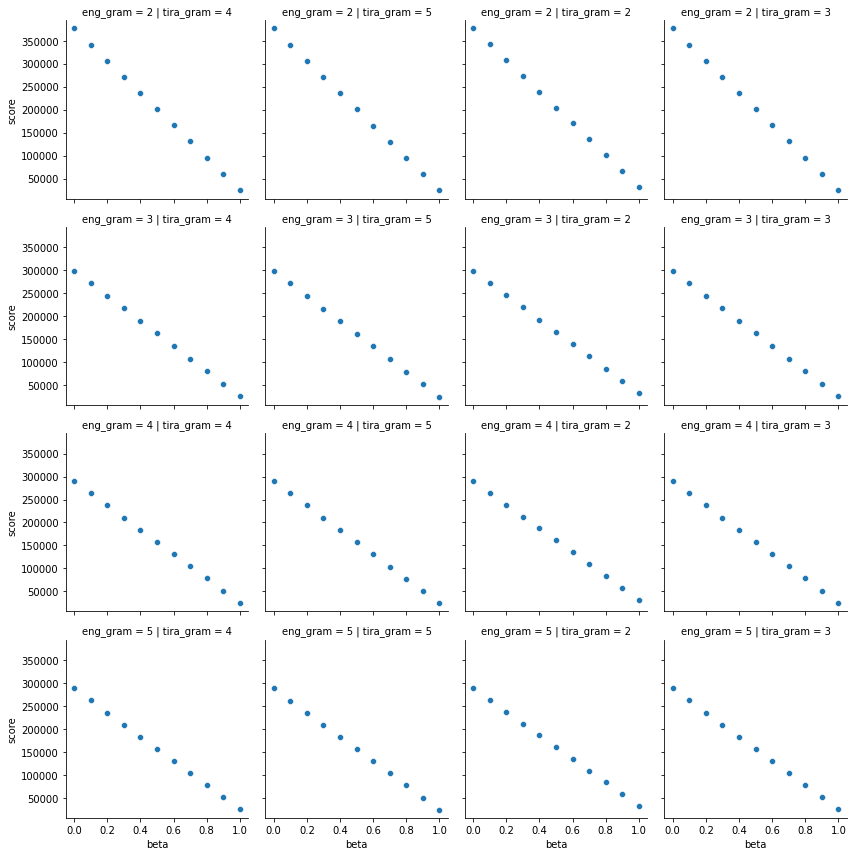

In [70]:
g=sb.FacetGrid(df, row='eng_gram', col='tira_gram')
g.map(sb.scatterplot,'beta', 'score')